# Problem Statement

Solar power consumption has been recorded by city councils at regular intervals. The reason behind doing so is to understand how businesses are using solar power so that they can cut down on nonrenewable sources of energy and shift towards renewable energy. Based on the data, build a forecasting model and provide insights on it. 

# Business Objective

The primary business objective is:

To forecast future solar power consumption trends among businesses in order to support policy-making and strategic planning aimed at increasing the adoption of renewable energy sources.

By accurately predicting solar energy usage patterns, city councils can:

Identify areas or sectors with low solar power usage.

Optimize incentives or subsidies to encourage renewable energy use.

Reduce dependency on nonrenewable energy sources.

Plan infrastructure needs for sustainable energy support.

Monitor environmental impact and progress toward sustainability goals.

# Constraints

Data Quality & Completeness:

Missing values, inconsistencies, or errors in recording intervals.

Limited historical data might affect the accuracy of long-term forecasts.

Temporal Granularity:

If data is not recorded at consistent time intervals, modeling could be challenging.

External Factors Not in Data:

Weather conditions, government policies, or technological advancements might influence solar usage but may not be reflected in the dataset.

Model Constraints:

Computational constraints based on available hardware or software.

Need for interpretable models if decisions are to be explained to policymakers.

Forecast Horizon:

Short-term vs long-term forecasting could demand different approaches and yield different accuracy levels.

Scalability & Generalization:

Model must be generalizable across different regions or business sectors if deployed widely.

# 2. DATA PRE-PROCESSING

In [18]:
# Step 1: Load the dataset
import pandas as pd
df = pd.read_csv("solarpower.csv")

In [20]:
# Step 2: Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

In [22]:
# Step 3: Sort the data by date (important for time series)
df = df.sort_values('date')

In [24]:
# Step 4: Create new column for daily solar power usage from cumulative usage
df['daily_power'] = df['cum_power'].diff()


In [26]:
# Step 5: Drop the first row which will have NaN after differencing
df = df.dropna().reset_index(drop=True)

## 2.1 DATA CLEANING & FEATURE ENGINEERING

In [29]:
# Step 6: Check and handle missing values (after differencing)
# (In this case we already dropped the first NaN row)
print("Missing values in each column:\n", df.isnull().sum())

Missing values in each column:
 date           0
cum_power      0
daily_power    0
dtype: int64


## 2.2 OUTLIER TREATMENT

In [32]:
# Step 7: Calculate IQR for daily_power
Q1 = df['daily_power'].quantile(0.25)
Q3 = df['daily_power'].quantile(0.75)
IQR = Q3 - Q1

In [34]:
# Step 8: Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [36]:
# Step 9: Create a cleaned column with outliers masked
df['daily_power_clean'] = df['daily_power'].mask(
    (df['daily_power'] < lower_bound) | (df['daily_power'] > upper_bound)
)

In [38]:
# Step 10: Fill the masked outliers using interpolation
df['daily_power_clean'] = df['daily_power_clean'].interpolate()

In [44]:

# Step 11: Final cleaned dataset preview
print(df[['date', 'cum_power', 'daily_power', 'daily_power_clean']].head())

        date  cum_power  daily_power  daily_power_clean
0 2011-10-27       10.2         10.1               10.1
1 2011-10-28       20.2         10.0               10.0
2 2011-10-29       29.6          9.4                9.4
3 2011-10-30       34.2          4.6                4.6
4 2011-10-31       38.0          3.8                3.8


# 3.	Exploratory Data Analysis (EDA):


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

## 3.1 SUMMARY STATISTICS

In [50]:
# Print summary statistics for daily solar power usage
summary_stats = df['daily_power_clean'].describe()
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
 count    2557.000000
mean       10.997223
std         8.209054
min         0.000000
25%         4.000000
50%         9.700000
75%        17.000000
max        34.000000
Name: daily_power_clean, dtype: float64


## 3.2 IDENTIFY THE TREND

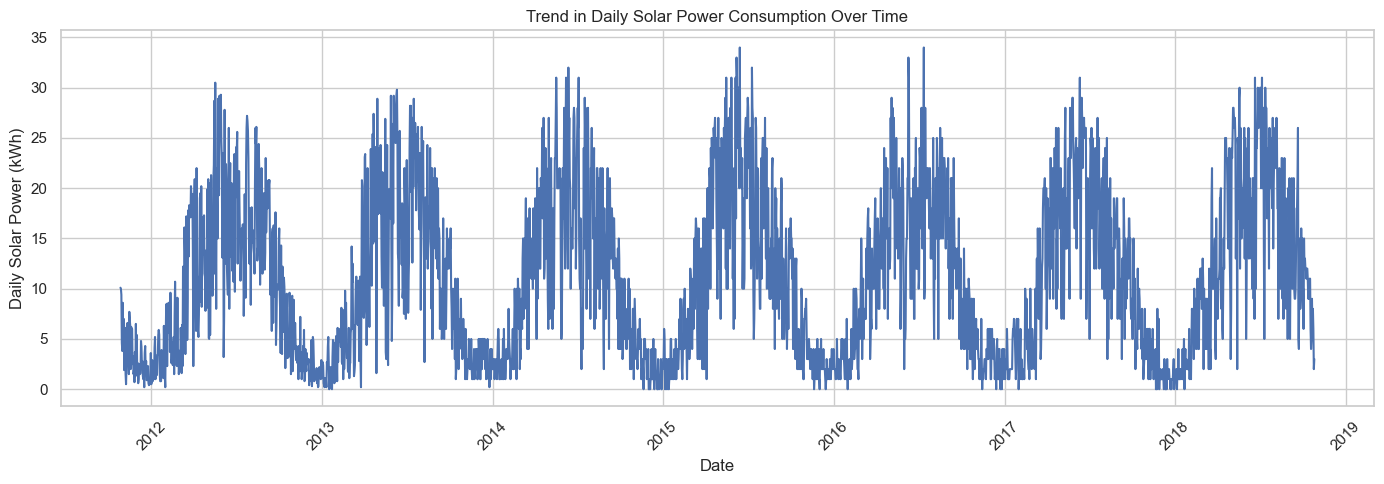

In [53]:
plt.figure(figsize=(14, 5))
sns.lineplot(x='date', y='daily_power_clean', data=df)
plt.title('Trend in Daily Solar Power Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Solar Power (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3.3 IDENTIFY SEASONALITY

In [56]:
# Extract month and year for seasonal analysis
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

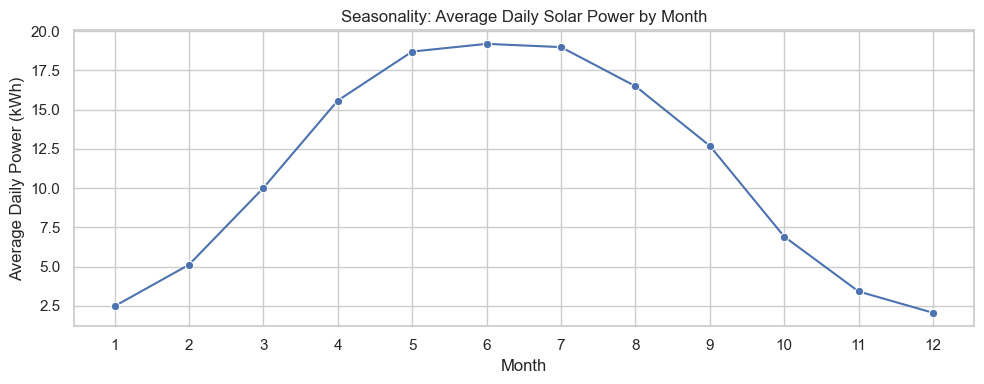

In [58]:
# Average daily power per month (across all years)
monthly_avg = df.groupby('month')['daily_power_clean'].mean()

plt.figure(figsize=(10, 4))
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values, marker='o')
plt.title('Seasonality: Average Daily Solar Power by Month')
plt.xlabel('Month')
plt.ylabel('Average Daily Power (kWh)')
plt.xticks(ticks=range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()


#  4. Model Building

In [61]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [63]:
#STEP 1: Prepare time series
ts = df.set_index('date')['daily_power_clean']

In [117]:
# Split into train (80%) and test (20%)
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]
train = train.asfreq('D')

## 4.1: Forecasting with Moving Average 

In [67]:
# Use last 7-day moving average for forecast
ma_forecast = train.rolling(window=7).mean().iloc[-1]
ma_predictions = [ma_forecast] * len(test)  # flat forecast

## 4.2: Exponential Smoothing Models

In [119]:
# 1. Simple Exponential Smoothing (no trend/seasonality)
ses_model = SimpleExpSmoothing(train).fit()
ses_forecast = ses_model.forecast(len(test))

In [121]:
# 2. Holt’s Linear Trend Model
holt_model = Holt(train).fit()
holt_forecast = holt_model.forecast(len(test))

In [123]:
# 3. Holt-Winters (seasonality assumed yearly: 365 days)
hw_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=365).fit()
hw_forecast = hw_model.forecast(len(test))

In [125]:
# 4. ARIMA model (simple manual config, ideally should use auto_arima for best parameters)
arima_model = ARIMA(train, order=(5,1,0)).fit()
arima_forecast = arima_model.forecast(len(test))

In [84]:
# --- Evaluate and Compare Models ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [86]:
errors = {
    "Moving Average": rmse(test, ma_predictions),
    "Simple Exponential Smoothing": rmse(test, ses_forecast),
    "Holt’s Linear": rmse(test, holt_forecast),
    "Holt-Winters": rmse(test, hw_forecast),
    "ARIMA": rmse(test, arima_forecast)
}

In [88]:
print("Model Evaluation (RMSE):")
for model, error in errors.items():
    print(f"{model}: {error:.2f}")

Model Evaluation (RMSE):
Moving Average: 13.35
Simple Exponential Smoothing: 12.32
Holt’s Linear: 15.22
Holt-Winters: 6.63
ARIMA: 11.42


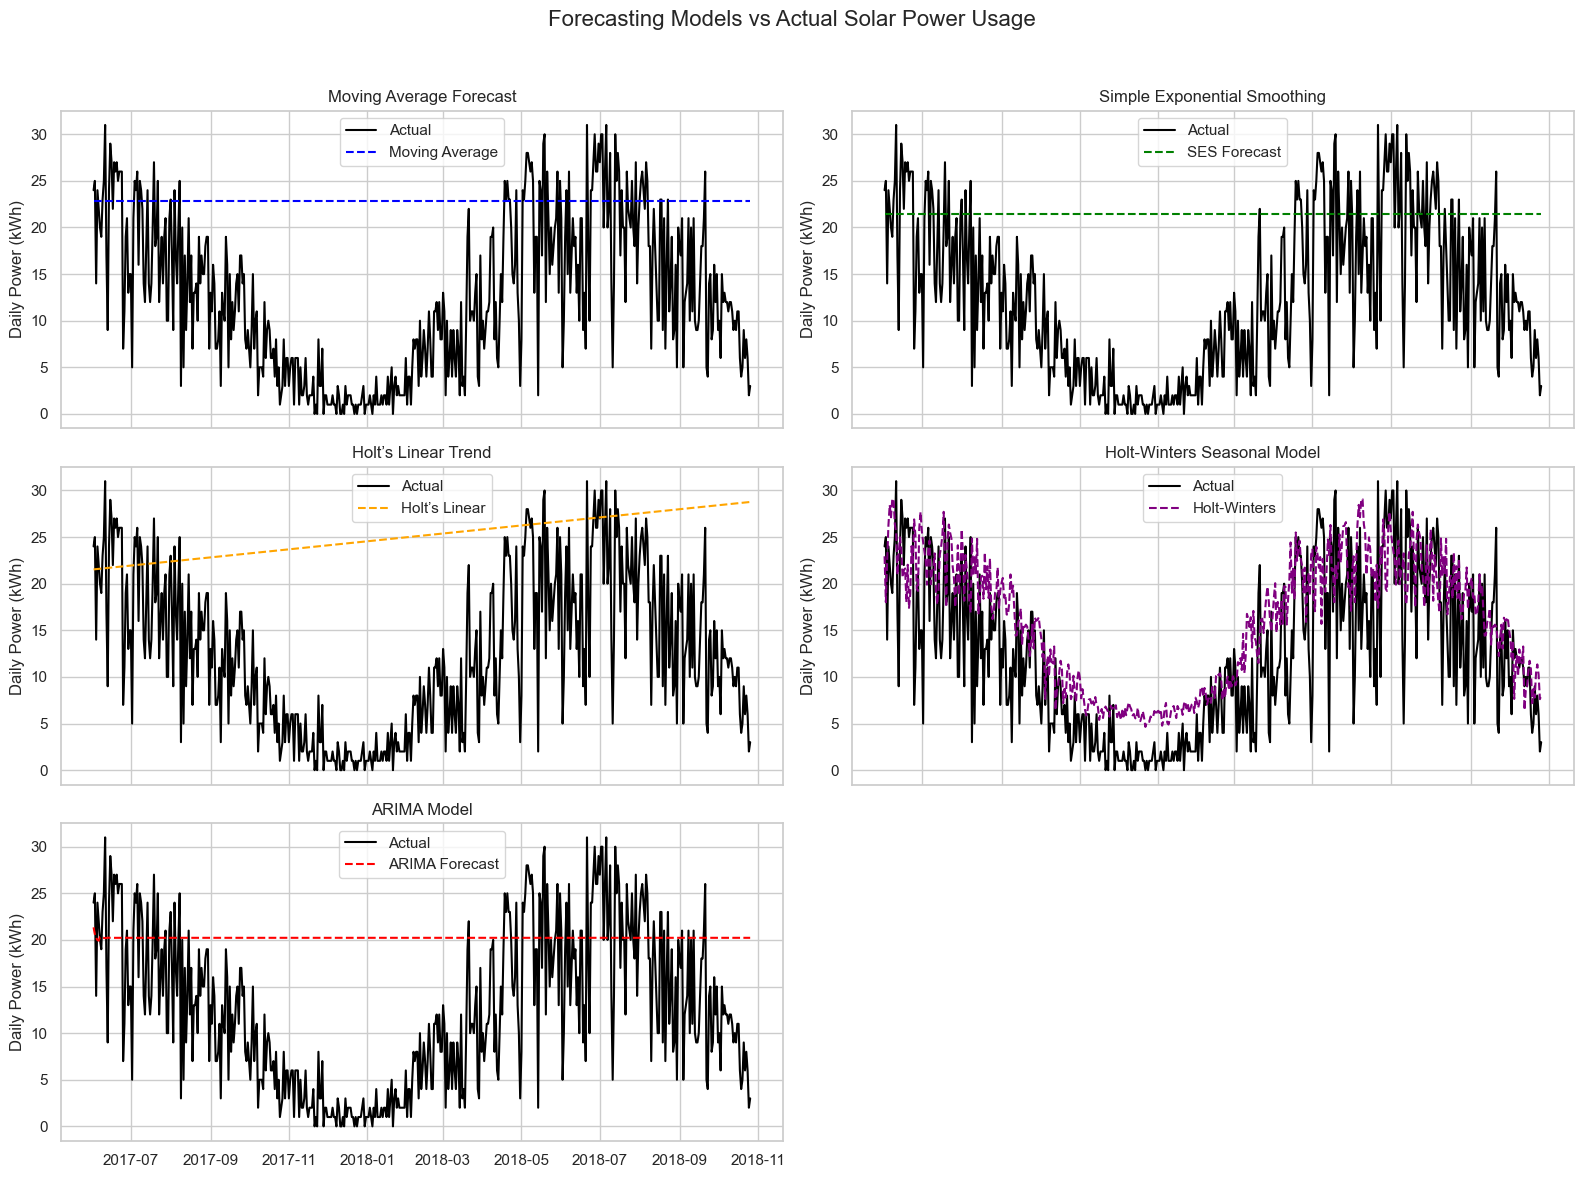

In [98]:
# Create subplots to visualize each model separately
fig, axs = plt.subplots(3, 2, figsize=(16, 12), sharex=True)

# Flatten axis array for easier indexing
axs = axs.flatten()

# Plot actual test data
axs[0].plot(test.index, test, label='Actual', color='black')
axs[0].plot(test.index, ma_predictions, label='Moving Average', color='blue', linestyle='--')
axs[0].set_title("Moving Average Forecast")
axs[0].legend()


axs[1].plot(test.index, test, label='Actual', color='black')
axs[1].plot(test.index, ses_forecast, label='SES Forecast', color='green', linestyle='--')
axs[1].set_title("Simple Exponential Smoothing")
axs[1].legend()

axs[2].plot(test.index, test, label='Actual', color='black')
axs[2].plot(test.index, holt_forecast, label='Holt’s Linear', color='orange', linestyle='--')
axs[2].set_title("Holt’s Linear Trend")
axs[2].legend()

axs[3].plot(test.index, test, label='Actual', color='black')
axs[3].plot(test.index, hw_forecast, label='Holt-Winters', color='purple', linestyle='--')
axs[3].set_title("Holt-Winters Seasonal Model")
axs[3].legend()

axs[4].plot(test.index, test, label='Actual', color='black')
axs[4].plot(test.index, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--')
axs[4].set_title("ARIMA Model")
axs[4].legend()

# Hide last empty subplot
axs[5].axis('off')

# Formatting
for ax in axs:
    ax.set_ylabel("Daily Power (kWh)")
    ax.grid(True)

plt.suptitle("Forecasting Models vs Actual Solar Power Usage", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [104]:
# === Forecasting next 30 days ===
# 1. Holt-Winters (best for seasonality) for future forecast
future_hw_model = ExponentialSmoothing(ts, seasonal='add', seasonal_periods=365).fit()
future_hw_forecast = future_hw_model.forecast(30)

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [106]:
# 2. ARIMA future forecast
future_arima_model = ARIMA(ts, order=(5,1,0)).fit()
future_arima_forecast = future_arima_model.forecast(30)

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [108]:
# Combine future forecast results
future_forecast_df = pd.DataFrame({
    'Date': pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=30),
    'Holt_Winters_Forecast': future_hw_forecast.values,
    'ARIMA_Forecast': future_arima_forecast.values
})

In [110]:
print("\nNext 30 days forecast:")
print(future_forecast_df.head())


Next 30 days forecast:
        Date  Holt_Winters_Forecast  ARIMA_Forecast
0 2018-10-27               6.771248        4.857754
1 2018-10-28               6.148658        4.721419
2 2018-10-29               4.409129        4.709233
3 2018-10-30               6.868475        4.439834
4 2018-10-31               7.711785        4.126554


In [112]:
# Optional: Save to CSV
future_forecast_df.to_csv("Solar_forecast_30_days.csv", index=False)
print("30-day future forecast saved as 'future_forecast_30_days.csv'")

30-day future forecast saved as 'future_forecast_30_days.csv'


# Conclusion
Better Energy Planning: Forecasts help manage daily and seasonal solar power usage.

Cost Savings: Reduces reliance on costly nonrenewable energy.

Sustainability Goals: Tracks progress in adopting clean energy.

Operational Efficiency: Helps prepare for low solar output days.

Data-Driven Decisions: Supports policies, budgeting, and infrastructure planning.